Each task that is proposed to be completed as part of the homework has a declared "price" in points. The maximum possible amount is 10 points, and together with the bonus assignment - 12 points. It is not necessary to complete all the tasks, only a part can be done. Most of the points expect you to write working Python code; sometimes you will need to write comments - for example, to compare several approaches to solve the same problem. Also you can add more cells for your convenience if you need.

This homework focuses on clustering. We will work with images of handwritten digits, learn how to cluster them using two different methods (hierarchical clustering and the 𝐾-means algorithm), evaluate the quality of the partition and choose the optimal number of clusters, as well as visualize intermediate results.

## 1. Loading data
The data we will be working with is available in the scikit-learn library (`sklearn` module) in the `datasets` submodule via the `load_digits` function. The data contains 1,797 observations, each of which is 8×8 pixel image of a handwritten digit from 0 to 9. This is about the same amount of each digit (about 180).

For convenience, every image expands to a 64 (8×8) row, so entire numpy array is 1797×64. The color intensity in each pixel is encoded with an integer from 0 to 16.

In addition to images, their labels are also known. In this task, we will assume that the labels (as well as their amount) are unknown and try to group the data in such a way that the resulting clusters 'better match' the original ones. Possible options for determining the 'better match' are presented later.

**(0.25 points)** Load the images into `X` variable, and their labels into `y` variable.

In [1]:
!pip install hdbscan

     |████████████████████████████████| 5.2 MB 5.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.28-cp37-cp37m-linux_x86_64.whl size=2330781 sha256=53198d276c9edace54d8f7f4c442c2e7631877da4cf9ba7cf68ff904b1e3a5e6
  Stored in directory: /root/.cache/pip/wheels/6e/7a/5e/259ccc841c085fc41b99ef4a71e896b62f5161f2bc8a14c97a
Successfully built hdbscan


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import v_measure_score
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import hdbscan

In [3]:
X, y = load_digits(return_X_y=True)

In [4]:
assert X.shape == (1797, 64)
assert y.shape == (1797,)

**(0.5 points)** Visualize the first 10 images.

- Arrange images on a grid rather than in a row. You may need the `subplot` and `imshow` functions from the `pyplot` module in the `matplotlib` library.
- You will also need to reshape the images to 8×8.
- Remove ticks and labels from both axes. The `xticks` and `yticks` functions or the `tick_params` function from `pyplot` can help you with this.
- Make the output good sized with the `figure` function from `pyplot`.

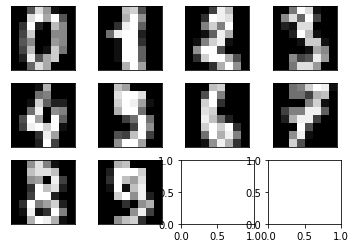

In [5]:
fig, ax = plt.subplots(3, 4)
plt.gray()
for axis, digit in zip(ax.flat, X[:10]):
    axis.set(xticks=[], yticks=[])
    axis.imshow(digit.reshape(8,8), interpolation=None)
plt.show()

## 2. Clustering and quality evaluation

**(2 points)** Implement the the KMeans algorithm. Use objective function $L = \sum_{i=1}^{n}|x_{i}-Z_{A(x_{i})}|^{2}$, where $Z_{A(x_{i})}$ is the center of the cluster corresponding to $x_{i}$ object.

In [6]:
from sklearn.exceptions import NotFittedError
from numpy.random import RandomState
from scipy.spatial.distance import cdist

In [7]:
class CustomKMeans:
    def __init__(self, n_clusters=2, max_iter=30, n_init=10, random_state=42):
        '''K-Means clustering.
        
        Args:
            n_clusters: int, default=2
                The number of clusters to be formed is also 
                the number of centroids to generate. 
            max_iter: int, default=300
                Maximum number of iterations of the k-means algorithm for a
                single run.
            n_init: int, default=10
                Number of time the k-means algorithm will be run with different
                centroid seeds. The final results will be the best output of
                n_init consecutive runs in terms of objective function.
            random_state: int, default=42
                Random state.
        '''
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.random_state = RandomState(seed=random_state)
        
    def calculate_distances_to_centroids(self, X, cluster_centers):
        """
        Returns (n, c) matrix where the element at position (i, j) 
        is the distance from i-th object to j-th centroid."""
        # <your code>
        dist = cdist(X, cluster_centers, metric='euclidean')
        return dist
    
    def update_centroids(self, X, nearest_clusters):
        """
        Returns numpy array of shape (n_clusters, n_features) - 
        new clusters that are found by averaging objects belonging 
        to the corresponding cluster."""
        # <your code>
        centroid = []
        for claster in set(nearest_clusters):
            cent = np.mean(X[nearest_clusters == claster,:],axis=0)
            centroid.append(cent)
        centroids = np.vstack(centroid)
        return centroids



   #НЕ СДЕЛАНО
    def fit(self, X):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        """
        assert X.shape[0] >= self.n_clusters
        # <your code>
        
        return self
            
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted cluster labels.
        """
        if hasattr(self, 'cluster_centers_'):
            # <your code>
            dist = np.linalg.norm(X - self.cluster_centers_[0,:],axis=1).reshape(-1,1)
        for class_ in range(1,self.n_clusters):
            dist = np.append(dist, np.linalg.norm(X - self.cluster_centers_[class_,:],axis=1).reshape(-1,1),axis=1)
            y = np.argmin(dist,axis=1)
            return y
        else: 
            raise NotFittedError("CustomKMeans instance is not fitted yet")

**(1 points)** Get the `X` array partition into 10 clusters. Visualize the centers of clusters.
- We will assume that the center of the cluster is average value of all observations belonging to the cluster.
- The cluster centers should have the same shape as our observations (64). So you have to average the points across the rows.

In [8]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10).fit(X)
custom_kmeans_labels = kmeans.labels_
centers = kmeans.cluster_centers_.reshape(10, 8, 8)

In [13]:
centers = abs(centers - 16)

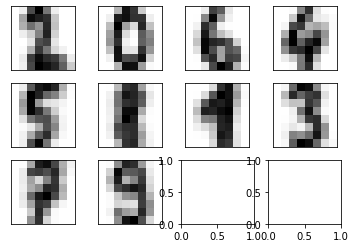

In [14]:
fig, ax = plt.subplots(3, 4)
plt.gray()
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)
plt.show()
assert custom_kmeans_labels.shape == (1797,)

**(0.5 points)** Experiment with `max_iter` and `n_init` parameters. Look at the range of values of the objective function, it's best values, at what parameters and how often they are achieved.

In [ ]:
# from sklearn.metrics import accuracy_score
# max_iter = range(1, 300, 2)
# n_init = range(1, 150, 2)


Now we will use two popular algorithms: hierarchical clustering and $K$-means clustering. These and other algorithms are available in the `scikit-learn` module in the `cluster` submodule. Hierarchical clustering is called `AgglomerativeClustering`, and the $K$-means method is called `KMeans`.

**(0.5 points)** Use each of the two methods: hierarchical clustering and KMeans. Get the `X` array partition into 10 clusters.

- Note that `AgglomerativeClustering` does not have a `predict` method, so you can either use the `fit_predict` method or use the `fit` method and then look at the `labels_` attribute of the class instance.
- Kmeans performs multiple runs (default 10) with random centers and then returns the best partition in terms of average distance within the clusters. You can increase the number of runs to improve the quality of predictions in the `i_init` parameter.

In [15]:
hierarchical_labels = AgglomerativeClustering(n_clusters=10).fit_predict(X)
kmeans_labels = KMeans(n_clusters=10, n_init=100).fit_predict(X)

In [16]:
assert hierarchical_labels.shape == (1797,)
assert kmeans_labels.shape == (1797,)

**(0.5 points)** Visualize the centers of clusters obtained by both methods.

In [17]:
hierarchical_centers = np.array([np.sum(X[np.where(hierarchical_labels == i)], axis=0) /
                                 len(X[np.where(hierarchical_labels == i)]) for i in hierarchical_labels])

kmeans_centers = np.array([np.sum(X[np.where(kmeans_labels == i)], axis=0) /
                           len(X[np.where(kmeans_labels == i)]) for i in kmeans_labels])

## Hierarchical method

In [18]:
hierarchical_centers = abs(hierarchical_centers - 16)
kmeans_centers = abs(kmeans_centers - 16)

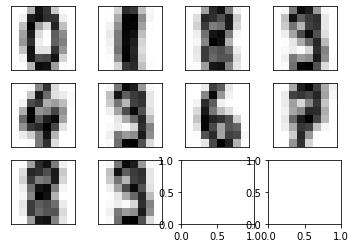

In [19]:
fig, ax = plt.subplots(3, 4)
plt.gray()
for axis, digit in zip(ax.flat, hierarchical_centers[:10]):
    axis.set(xticks=[], yticks=[])
    axis.imshow(digit.reshape(8,8))
plt.show()

## KMeans method

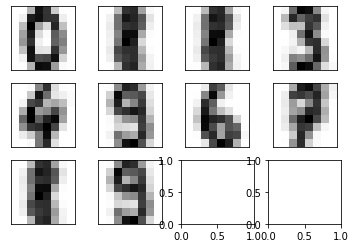

In [20]:
fig, ax = plt.subplots(3, 4)
plt.gray()
for axis, digit in zip(ax.flat, kmeans_centers[:10]):
    axis.set(xticks=[], yticks=[])
    axis.imshow(digit.reshape(8,8))
plt.show()

При использовании иерархического метода, визуализированные изображения получаются более четкими. Особенно заметно это по цифрам 3 и 8.

In a situation where the true number of classes is unknown, we can select it by maximazing some metric.

When we can set some distance function between our observations, we can consider the `silhouette` distance as a function of measuring the quality of the clustering. Let's show how it is calculated:

Let $X$ – set of observations, $M \subset X$ – one of the clusters obtained as a result of clustering process, $\rho$ – some metric on $X$. Let's choose one observation $x \in M$. Denote $a(x)$ as the average distance from $x$ to  $x'$ points from the same cluster:
$$
a(x) = \frac{1}{|M| - 1} \sum_{x' \in M,\, x' \ne x} \rho(x,\, x')
$$

Denote $b(x)$ as minimun of average distances from $x$ to $x''$ from some other cluster $N$:
$$
b(x) = \min_{N \ne M} \frac{1}{|N|} \sum_{x'' \in N} \rho(x,\, x'')
$$

The silhouette is difference between a(x) and b(x), normalized to $[-1, \, 1]$ and averaged over all observations:
$$
\frac{1}{|X|} \sum_{x \in X} \frac{b(x) - a(x)}{\max(a(x),\, b(x))}
$$

The implementation of this metric in the `scikit-learn` is the `silhouette_score` function from the `metrics` submidule.

**(0.75 point)** For each $K$ between 2 and 20 inclusive, partition of the array $X$ into $K$ clusters using both methods. Calculate the silhouette score and visualize it for both methods on the same plot ($K$ on the $x$ axis and silhouette score on the $y$ axis). Sign the axes and make a legend.

In [25]:
ss_kmeans = []
ss_hierarchical = []
clusters = np.array(range(2, 21))
for k in clusters:
    kmeans = KMeans(n_clusters=k, n_init=100).fit(X).labels_
    hierarchical = AgglomerativeClustering(n_clusters=k).fit(X).labels_

    ss_kmeans.append(silhouette_score(X, kmeans))
    ss_hierarchical.append(silhouette_score(X, hierarchical))

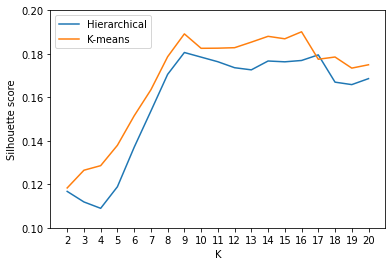

In [26]:
plt.axis([1,21,0.10,0.20])
plt.xticks(clusters)
plt.plot(np.arange(2,21,1), ss_hierarchical)
plt.plot(np.arange(2,21,1), ss_kmeans)
plt.xlabel('K')
plt.ylabel('Silhouette score')
plt.legend(['Hierarchical', 'K-means'])
plt.show()

In [27]:
print(max(ss_kmeans), max(ss_hierarchical))

0.19014668764090664 0.18061975703867697


На графиках можно заметить, что своих максимальных значений функции достигают при k = 9.

When we know the true clustering labels, the clustering result can be compared to them using measures such as `homogeneity`, `completeness` and their harmonic mean - $V$-score. The definitions of these quantities are rather bulky and are based on the [entropy of the probability distribution](https://ru.wikipedia.org/wiki/Информационная_энтропия). Details are given in [this article](http://aclweb.org/anthology/D/D07/D07-1043.pdf). In practice, it's enough to know that `homogeneity`, `completeness` and $V$-score are in the range from 0 and 1, and the more, the better.

Since we know what digit each image is (`y` array), we can compare the clustering results to it using the measures listed above.

**(0.5 points)** Repeat the previous task using $V$-measure instead of silhouette.

In [28]:
vms_kmeans = []
vms_hierarchical = []
for k in clusters:
    kmeans = KMeans(n_clusters=k, n_init=100).fit(X).labels_
    hierarchical = AgglomerativeClustering(n_clusters=k).fit(X).labels_

    vms_kmeans.append(v_measure_score(y, kmeans))
    vms_hierarchical.append(v_measure_score(y, hierarchical))

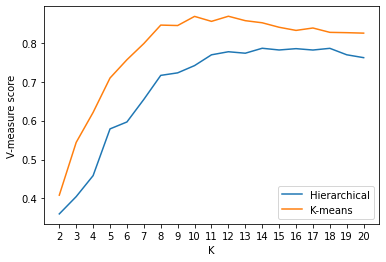

In [29]:
plt.plot(np.arange(2,21,1), vms_kmeans)
plt.plot(np.arange(2,21,1), vms_hierarchical)
plt.xticks(clusters)
plt.xlabel('K')
plt.ylabel('V-measure score')
plt.legend(['Hierarchical', 'K-means'])
plt.show()

In [30]:
print(max(vms_kmeans), max(vms_hierarchical))

0.7861763634717905 0.86854875186737


Максимальное значение v-measure при иерархической классификации достигается при k = 17. А при KMeans при k = 12.

## 3. Feature space dimensionality reduction

In some cases, especially when there are a large number of features, when not all of them are informative, and some of them are correlated, it can be useful to reduce the dimension of the feature space. This mean that instead of $d$ original features, we will go to $d'\ll d$ new ones. And if earlier our data were presented in the form of an $n×d$ matrix, then it will presented as a $n×d'$.

There are two popular dimensionality reduction approaches:
- select new features from existing features;
- extract the new features by transforming old ones, for example, by making $d'$ different linear combinations of columns of an $n×d$ matrix.

One widely used dimensionality reduction technique is the Singular Value Decomposition (SVD). This method allows you to construct any number $d'\leq d$ of new features in such a way that they are the most informative (in some sense).

The `scikit-learn` module has several implementations of singular value decomposition. We will use the `TruncatedSVD` class from the `decomposition` submodule.

**Note:** The singular value decomposition of the matrix $M$ is usually written as $M=U \Sigma V^{*}$. `TruncatedSVD`, in turn, returns only the $d'$ first columns of the matrix $U$.

**(0.75 point)** Perform a singular value decomposition of the $X$ matrix, leaving 2, 5, 10, 20 features. In each case, perform hierarchical clustering and $K$-Means clustering (take the number of clusters equal to 10). Calculate the silhouette and $V$-score and compare them to corresponding values obtained from the original data.

**Note**: It is not valid to compare the silhouette calculated with different metrics. Even if we use the same metric function when calculating the distance between points in the data, after applying dimensionality reduction or other data transformations, we will (not always) get different silhouette scores. Therefore, after training the clustering algorithm, to compare the result of clustering, you need to calculate the silhouette on the original data.

## Silhouette score

In [31]:
for i in [2, 5, 10, 20]:
    X_svd = TruncatedSVD(n_components=i, random_state=0).fit_transform(X)
    hierarchical_svd = AgglomerativeClustering(n_clusters=10).fit(X_svd)
    kmeans_svd = KMeans(n_clusters=10, n_init=100).fit(X_svd)
    hierarchical_svd_score = silhouette_score(X_svd, hierarchical_svd.labels_)
    kmeans_svd_score = silhouette_score(X_svd, kmeans_svd.labels_)
    print(i, ' ', hierarchical_svd_score)
    print(i, ' ', kmeans_svd_score)
    print()

2   0.2808169970393252
2   0.3489698831340491

5   0.27274158281405486
5   0.31253007461876975

10   0.25071255951100785
10   0.26322563984276687

20   0.19566079881840043
20   0.21252202882889362



Наибольший скор, как при использовании KMeans, так и AgglomerativeClustering достигается при 2 признаках.

## V-score

In [32]:
for i in [2, 5, 10, 20]:
    X_svd = TruncatedSVD(n_components=i, random_state=0).fit_transform(X)
    hierarchical_svd = AgglomerativeClustering(n_clusters=10).fit(X_svd)
    kmeans_svd = KMeans(n_clusters=10, n_init=100).fit(X_svd)
    hierarcical_vms_svd = v_measure_score(y, hierarchical_svd.labels_)
    kmeans_vms_svd = v_measure_score(y, kmeans_svd.labels_)
    print(i, ' ', hierarcical_vms_svd)
    print(i, ' ', kmeans_vms_svd)
    print()

2   0.3337189903948925
2   0.34814173887857847

5   0.6756036446423491
5   0.6349670267154036

10   0.8259753348813222
10   0.7226312909441988

20   0.8171311050922185
20   0.7406627574454614



Наибольшее значение V-measure при использовании KMeans достигается при 20 признаках, а при использовании AgglomerativeClustering при 10.

Another popular dimensionality reduction approach that is useful for working with images is t-distributed stochastic neighbor embeddings, abbreviated `tSNE`. Unlike singular value decomposition, this it is non-linear transformation. It's main idea is to map points from a space of dimension `d` to another space of dimension 2 or 3 in such a way that the distances between points are mostly preserved. Mathematical details can be found, for example, [here](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding).

The implementation of `tSNE` in the `scikit-learn` library is the `TSNE` class in the `manifold` submodule.

**Note:** In recent years [UMAP](https://github.com/lmcinnes/umap) is often used istead of `tSNE`. It is a faster algorithm with similar properties. We don't ask you to use `UMAP` because it requires you to install another dependency, the `umap-learn` library. Those who wish can perform the following task using `UMAP`.

**(0.5 points)** Perform a tSNE-transform of the `X` matrix, leaving 2 features. Visualize the obtained data in the form of a scatter plot form: the first feature on the horizontal axis, and the second one the vertical axis. Color the points according to the digits they belong to.

- The `c` parameter in the plt.scatter function is responsible for the color of the points. Pass the true labels to it.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


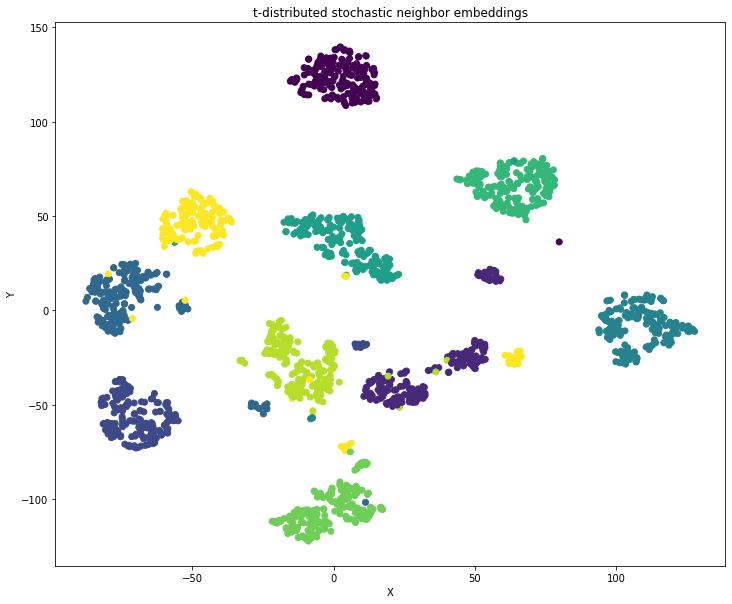

In [33]:
tsne = TSNE(n_components=2, n_iter=5000, init='pca', perplexity=15)
X_tsne = tsne.fit_transform(X)

fig, ax = plt.subplots(figsize=(12,10))
clusters = ax.scatter(x=X_tsne[:, 0], y=X_tsne[:, 1], c=y, cmap='viridis')
plt.title('t-distributed stochastic neighbor embeddings')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

**(0.5 points)** From the data transformed using the tSNE, perform hierarchical clustering and $K$-means clustering (take the number of clusters equal to 10). Calculate the silhouette and the $V$-score and compare them to corresponding values obtained from the original data.

## Silhouette score

In [34]:
hierarchical_svd = AgglomerativeClustering(n_clusters=10).fit(X_tsne)
kmeans_svd = KMeans(n_clusters=10, n_init=100).fit(X_tsne)
print(silhouette_score(X_tsne, hierarchical_svd.labels_), '|', ss_hierarchical[9])
print(silhouette_score(X_tsne, kmeans_svd.labels_), '|', ss_kmeans[9])

0.66620123 | 0.17637337987696772
0.6732814 | 0.18260636838085423


## V-measure score

In [35]:
hierarchical_svd = AgglomerativeClustering(n_clusters=10).fit(X_tsne)
kmeans_svd = KMeans(n_clusters=10, n_init=100).fit(X_tsne)
print(v_measure_score(y, hierarchical_svd.labels_), '|', vms_hierarchical[9])
print(v_measure_score(y, kmeans_svd.labels_), '|', vms_kmeans[9])

0.8959957322228514 | 0.8553799643497675
0.9116977717886767 | 0.7693272648369152


При использовании уменьшения размерности, скор получается гораздо выше, чем на оригинальных данных.

**(0.25 points)** Choose the best partition (in terms of silhouette or $V$-score) and visualize the centers of clusters with images. Did you managed to make each digit correspond to one center of the cluster?

In [36]:
hierarchical_labels = AgglomerativeClustering(n_clusters=10).fit_predict(X_tsne)
kmeans_labels = KMeans(n_clusters=10, n_init=100).fit_predict(X_tsne)

hierarchical_centers2 = np.array([np.sum(X[np.where(hierarchical_labels == i)], axis=0) /
                                 len(X[np.where(hierarchical_labels == i)]) for i in hierarchical_labels])

kmeans_centers2 = np.array([np.sum(X[np.where(kmeans_labels == i)], axis=0) /
                           len(X[np.where(kmeans_labels == i)]) for i in kmeans_labels])

## Hierarchical centers with TSNE

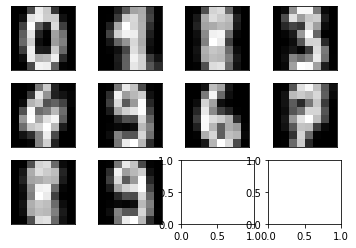

In [37]:
fig, ax = plt.subplots(3, 4)
plt.gray()
for axis, digit in zip(ax.flat, hierarchical_centers2[:10]):
    axis.set(xticks=[], yticks=[])
    axis.imshow(digit.reshape(8,8))
plt.show()


## KMeans centers with TSNE

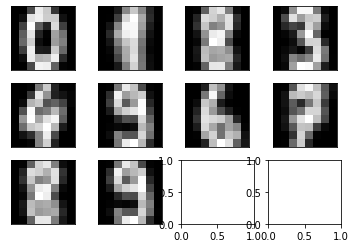

In [38]:
fig, ax = plt.subplots(3, 4)
plt.gray()
for axis, digit in zip(ax.flat, kmeans_centers2[:10]):
    axis.set(xticks=[], yticks=[])
    axis.imshow(digit.reshape(8,8))
plt.show()

Кластеры не соответствуют цифрам.

## 4. Results and bonus part

Write in free form what conclusions you made after completing this assignment. Answer the following questions:

**(0.5 points)** Which algorithm gives more meaningful results - hierarchical clustering or $K$- means clustering. Does it depend on the algorithm settings or on the quality evaluation method?

На данном наборе данных лучшие результаты были получены именно при использовании иерархической кластеризации, однако в некоторых моментах скор был выше и при использовании KMeans. Какой метод лучше и какой точнее будет зависеть от того, с какими данными мы работаем. К примеру, KMeans менее требовательный, поэтому больше подходит для данных больших размеров, нежели AgglomerativeClustering. Тем не менее для использования KMeans нам необходимо заранее знать количество кластеров, которое мы хотим получить, в то время как при использовании AgglomerativeClustering  можно выбрать любое количество кластеров, которое можно счесть подходящим. Так как при работе с KMeans один запуск выполняется со случайным выбором кластеров, результаты, полученные при многократном запуске алгоритма, могут различаться. В AgglomerativeClustering результаты воспроизводятся иерархически.

**(0.5 points)** Imagine the situation where after hierarchical clustering, you need to cluster new data in the same way without retraining the model. Suggest a method how you will do it and how you will measure the quality of clustering of new data.

Зная заранее, что мне будет необходимо делать кластеризацию 2 раза, я просто сделаю копию данных, которые буду потом кластеризировать. Для оценки качества кластеризации буду использовать Silhouette_score, чтобы оценить, насколько объект похож на свой кластер по сравнению с другими кластерами. V_measure_score, которая оценивает среднее гармоническое полноты и однородности кластеров. Также можно использовать calinski_harabasz_score, он показывает сумму дисперсий внутри и между кластерами. Скор выше, когда кластеры плотные и хорошо разделенные, что относится к стандартной концепции кластера. Davies_bouldin_score определяет среднее «сходство» между кластерами, где сходство — это мера, которая сравнивает расстояние между кластерами с размером самих кластеров. Ноль — это наименьший возможный результат. Значения, близкие к нулю, указывают на лучшее разделение.

**(0.5 points)** Does dimensionality reduction improve clustering results?

Уменьшение размерности данных помогает повысить качество их кластеризации. Вычислительная сложность для алгоритма кластеризации (KMeans), достаточно высока, особенно для больших наборов данных. Кроме того, количество вычислений расстояния увеличивается экспоненциально с увеличением
размерность данных. В многомерных данных некоторые признаки могут быть избыточными, коррелированными или вовсе не иметь значения. Такие фичи будут только усложнять процесс кластеризации, тем самым влияя на ее конечный результат. Для того, чтобы добиться более точной кластеризации нам необходимо уменьшать наш объем данных.

**(0.5 points)** How to evaluate the quality of dimensional reduction? Suggest at least 2 options.

1. Можно сравнить исходные кластеризованные данные с данными, полученными после уменьшения размерности. Оценив при этом сохранилась ли форма кластеров и расстояние между ними.
2. Также можно заново разбить данные на кластеры и оценить качество кластеризации. Здесь оно должно быть выше, чем на первоначальных данных.

**(Bonus 2 points)** Load the [MNIST Handwritten Digits](http://yann.lecun.com/exdb/mnist) dataset. You can also do it with `scikit-learn` as explained [here](https://stackoverflow.com/a/60450028). Explore the data and try to cluster it using different approaches. Compare results of these approaches using the silhouette and the $V$-score.

In [39]:
from sklearn.datasets import fetch_openml
X2, y2 = fetch_openml('mnist_784', version=1, return_X_y=True)
X2.shape

(70000, 784)

In [40]:
X2 = np.array(abs(X2-256))
X2 = X2.astype(int)

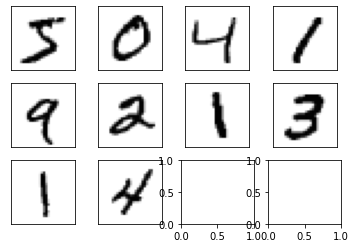

In [41]:
fig, ax = plt.subplots(3, 4)
plt.gray()
for axis, digit in zip(ax.flat, X2[:10]):
    axis.set(xticks=[], yticks=[])
    axis.imshow(digit.reshape(28,28))
plt.show()

In [42]:
tsne = TSNE()
X_t = tsne.fit_transform(X2)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


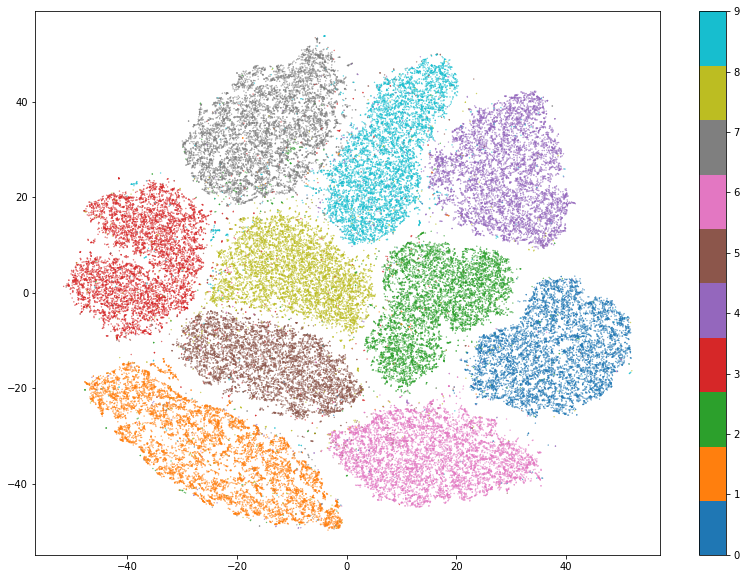

In [43]:
plt.cm.get_cmap('tab10', 10)
plt.figure(figsize=(14, 10), constrained_layout=False)
plt.scatter(X_t[:,0],X_t[:,1], s=0.1, c = y2.astype(int).values, cmap='tab10')
plt.colorbar()

In [44]:
km = KMeans(n_clusters=10, n_init=50).fit(X_t)
print(silhouette_score(X_t, km.labels_, metric='euclidean'))
print(v_measure_score(y2, km.labels_))

0.4008256
0.7975999483028685


In [45]:
from hdbscan import HDBSCAN
hdb = HDBSCAN(min_samples=10, min_cluster_size=500,).fit(X_t)
y_hdb = hdb.fit_predict(X_t)
print(silhouette_score(X_t, hdb.labels_, metric='euclidean'))
print(v_measure_score(y2, y_hdb))

0.38718042
0.9044026511008804
